# Dunkin assessment

In [1]:
# some imports used throughout script
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import uniform, norm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import ultranest

In [ ]:
# Import functions from helper function
from dunking_functions import encode_biscuit_type, washburn, run_pymc, calc_prob_in_distribution, calc_num_stds

### Big data collection

The first provided dataset contains the following data for each individual biscuit: 

1. gamma: tea surface tension, in N m−1.
2. phi: angle between the biscuit and the tea surface, in rad.
3. eta: tea dynamic viscosity, in Pa s
4. L: distance up the biscuit that the tea was absorbed, in m.
5. t: time biscuit was dunked for before measurement done, in s.
6. biscuit: type of biscuit that was dunked, out of Rich Tea, Hobnob or Digestive.


In [3]:
# load in dunking-data, and show dataframe

big_data = pd.read_csv("datasets/dunking-data.csv")
print(f"shape: {big_data.shape}")
big_data.head()

shape: (3000, 6)


,gamma,phi,eta,L,t,biscuit
0,0.073897,1.333006,0.000999,0.011196,19.362214,Digestive
1,0.080946,1.476758,0.001012,0.005894,11.852589,Digestive
2,0.087408,1.477141,0.000984,0.009249,24.793669,Digestive
3,0.070793,1.502001,0.001002,0.003774,16.292780,Hobnob
4,0.058917,1.548274,0.001004,0.002291,13.662271,Hobnob


In [4]:
# get names of all types of biscuits

biscuits = np.unique(big_data["biscuit"])
biscuits

array(['Digestive', 'Hobnob', 'Rich Tea'], dtype=object)

In [5]:
# encode names to integers

encode_biscuit_type(big_data, biscuits)
big_data['encoded biscuit']

added encoded biscuit column


0       0
1       0
2       0
3       1
4       1
       ..
2995    0
2996    1
2997    1
2998    0
2999    2
Name: encoded biscuit, Length: 3000, dtype: int64

# Classification of biscuit type 

In this section, a ML classifier is trained and tested on the dunking-data.csv. It aims to be able to classify biscuit type from the provided data (phi,eta,L,t).

GridSearchCV is used to determine the best hyperparameters for two models - random forest classifier, and support vector classification (SVC), and then use the better performing model throughout the rest of the script.



In [6]:
train, test = train_test_split(big_data, test_size=0.4, random_state=0)

# scale data
scaler = StandardScaler()
scaled_training_features = scaler.fit_transform(train.drop(['biscuit', 'encoded biscuit'], axis=1))
scaled_test_features = scaler.fit_transform(test.drop(['biscuit', 'encoded biscuit'], axis=1))

training_results = train['encoded biscuit']
true_test_vals = test['encoded biscuit']

In [7]:
# use GridSearchCV
rfc_param_grid = [
    {'n_estimators': [1000]},   # this value were determined as optimal using GridSearchCV - more trees worked better than fewer trees.
  {'max_features': [ None]}     # they have been narrowed down in order to run faster. 
 ]

# these values have not been narrowed down, just to show how the gridsearch was done. 
svc_param_grid = [
  {'C': [5000, 1000, 100, 10, 5],  
  'gamma': [0.001, 0.01, 0.1, 8, 'scale', 'auto'], 
  'kernel': ['rbf']} 
 ]

In [8]:
# Determine best model to use

methods = {'Random Forest': [RandomForestClassifier(random_state=0), rfc_param_grid], 'SVM': [SVC(random_state=0), svc_param_grid] }

current_f1 = 0
for i, method in methods.items():
    print(i)
    
    # Do gridsearchcv, and determine best estimator for each method
    gscv = GridSearchCV(method[0], method[1], scoring="f1_weighted")
    gscv.fit(scaled_training_features, training_results)
    print(f"{i} BEST ESTIMATOR: {gscv.best_estimator_}")
    print(f'Estimator Top F1-Score: {gscv.best_score_:.3f}')
    
    # Only update model if the new model is better
    if gscv.best_score_ > current_f1:
        print("Updating best model")
        
        best_estimator = gscv.best_estimator_
        predicted_test_vals = best_estimator.predict(scaled_test_features)
        
        f1score = f1_score(true_test_vals, predicted_test_vals, average='weighted')
        
        print(f'True F1-Score: {f1score:.3f}')

Random Forest


Random Forest BEST ESTIMATOR: RandomForestClassifier(max_features=None, random_state=0)
Estimator Top F1-Score: 0.807
Updating best model
True F1-Score: 0.812
SVM
SVM BEST ESTIMATOR: SVC(C=5000, gamma=0.01, random_state=0)
Estimator Top F1-Score: 0.920
Updating best model
True F1-Score: 0.913


It can be seen here that the SVC model consistently produces a much greater f1-score than the random forest model. The SVC model will be used throughout the rest of this analysis.  

In [9]:
# compare raw number of predicted biscuit types and true biscuit types

max_num_predictions = 0
for i, biscuit in enumerate(biscuits):
    num_true_test_vals = len(true_test_vals[true_test_vals == i])
    num_pred_test_vals = len(predicted_test_vals[predicted_test_vals == i])
    
    print( f"Number of true {biscuit} values: {num_true_test_vals}")
    print( f"Number of predicted {biscuit} values: {num_pred_test_vals}")
    
    max_num_predictions = max(max_num_predictions, num_pred_test_vals)

Number of true Digestive values: 401
Number of predicted Digestive values: 394
Number of true Hobnob values: 394
Number of predicted Hobnob values: 384
Number of true Rich Tea values: 405
Number of predicted Rich Tea values: 422


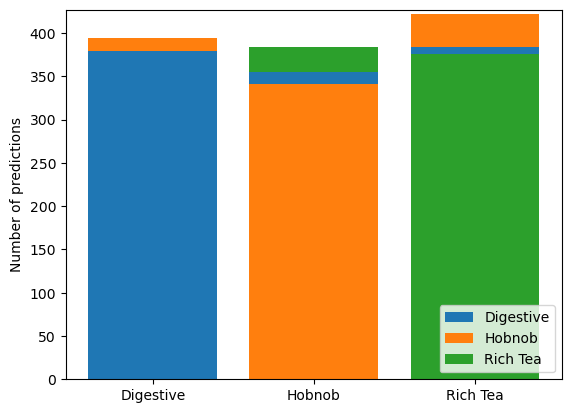

In [10]:
# plot bar chart

fig,ax = plt.subplots()

for i, biscuit in enumerate(biscuits):
    # Get values where this biscuit was predicted
    biscuit_prediction = np.where(predicted_test_vals==i, True, False)

    # Filter test values to just these biscuit predictions
    biscuit_test = true_test_vals[biscuit_prediction]
    
    # Number of correct predictions
    correct_predictions = len( biscuit_test[biscuit_test==i] )
    
    ax.bar(biscuit, correct_predictions, color=f"C{i}", label=biscuit)
    
    base = correct_predictions
    for j in range(len(biscuits)):
        if j != i:
            # NUmber of incorrect predictions, recording which biscuit was predicted instead
            incorrect_predictions = len( biscuit_test[biscuit_test==j] )
            ax.bar(biscuit, incorrect_predictions, bottom=base, color=f"C{j}")
            base += incorrect_predictions
            
ax.set_ylabel("Number of predictions")
ax.set_ylim(0, max_num_predictions+5)
ax.legend(loc="lower right");

In [11]:
# metrics

precision = precision_score(true_test_vals, predicted_test_vals, average='weighted')
print(f'Precision: {precision:.3f}')

recall = recall_score(true_test_vals, predicted_test_vals, average='weighted')
print(f'Recall: {recall:.3f}')

f1score = f1_score(true_test_vals, predicted_test_vals, average='weighted')
print(f'F1-Score: {f1score:.3f}')

Precision: 0.914
Recall: 0.913
F1-Score: 0.913


### Microscopy Measurements

The next provided dataset was generated by taking a subset, one-sixth, of the dunking-data.csv dataset used in the analysis above. However, the biscuit type label has been dropped, and instead it includes the pore radius of the biscuits. This was measured using microscopy. 

Therefore, the columns of this dataset are:
1. gamma: tea surface tension, in N m−1.
2. phi: angle between the biscuit and the tea surface, in rad.
3. eta: tea dynamic viscosity, in Pa s
4. L: distance up the biscuit that the tea was absorbed, in m.
5. t: time biscuit was dunked for before measurement done, in s.
6. r: the radius of the biscuit pores, in m


In [12]:
# Show dataset

microscopy_data = pd.read_csv("datasets/microscopy-data.csv")
microscopy_data.head()

,gamma,phi,eta,L,t,r
0,0.084596,1.557367,0.000981,0.003221,24.231107,7.453712e-07
1,0.064291,1.538842,0.000998,0.002395,22.169765,2.600680e-07
2,0.086224,1.546138,0.001008,0.003036,23.257709,3.734618e-07
3,0.082859,1.566878,0.000997,0.001261,12.717432,7.567173e-07
4,0.090832,1.570229,0.001002,0.000576,15.189146,8.239067e-07


In [13]:
# Make predictions of biscuit type for each row. 

# scaled test data (drop the microscopy true r values)
micro_model_features = microscopy_data.drop(['r'], axis=1)
print(f"{micro_model_features.columns}")
scaled_micro_features = scaler.fit_transform(micro_model_features)

# Make predictions for biscuit type of each row using the best model determined above
micro_predictions = best_estimator.predict(scaled_micro_features)
len(micro_predictions)


Index(['gamma', 'phi', 'eta', 'L', 't'], dtype='object')


500

In [14]:
# Determine true distribution (combine the two datasets, and compare biscuit type and measured radius)

training_merged = big_data.merge(microscopy_data, how='inner')
true_distributions = training_merged[['encoded biscuit', 'r']].copy()
true_distributions

,encoded biscuit,r
0,0,7.797961e-07
1,0,8.189772e-07
2,1,3.639434e-07
3,2,3.198697e-07
4,2,2.973448e-07
...,...,...
495,1,4.176549e-07
496,2,3.187500e-07
497,2,3.194081e-07
498,0,7.453712e-07


Digestive
predicted mean: 8.03e-07
true mean: 8.03e-07
predicted std: 5.97e-08
true std: 5.8e-08

Hobnob
predicted mean: 5.2e-07
true mean: 4.96e-07
predicted std: 8.66e-08
true std: 8e-08

Rich Tea
predicted mean: 3.27e-07
true mean: 3.04e-07
predicted std: 9.36e-08
true std: 4.7e-08



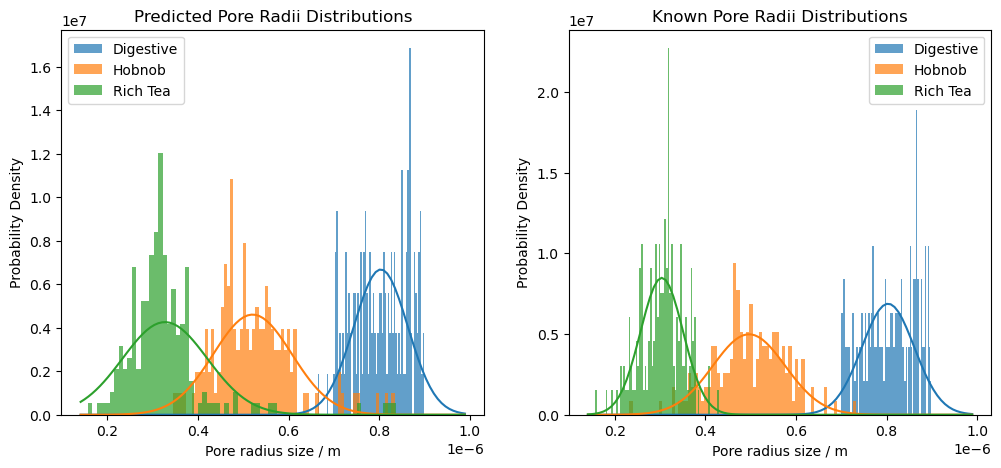

In [15]:
# compare distributions using the predicted and true values for biscuit type
# plot radii distribution of each biscuit as histograms

fig, ax = plt.subplots(1,2,figsize=(12,5))

biscuit_summaries = {}

xmin = np.min(true_distributions["r"])
xmax = np.max(true_distributions["r"])

for i, biscuit in enumerate(biscuits):
    print(f"{biscuit}")
    
    # get rows where encoded biscuit was predicted as i
    map = np.where(micro_predictions==i, True, False)
    
    # get r values for these rows
    biscuit_r_data = microscopy_data["r"][map]
    
    # get true r values for these biscuits (using merged dataset)
    true_biscuit_r_data = true_distributions["r"][true_distributions['encoded biscuit']==i]
    
    # plot as 2 histograms
    ax[0].hist(biscuit_r_data, bins=70, alpha=0.7, density=True, label=biscuit)
    ax[1].hist(true_biscuit_r_data, bins=70, alpha=0.7, density=True, label=biscuit)
    
    # get mean and std of each distribution
    mean, std = norm.fit(biscuit_r_data)
    true_mean, true_std = norm.fit(true_biscuit_r_data)
    
    
    x = np.linspace(0.9*xmin, 1.1*xmax, 100)
    p = (norm.pdf(x, mean, std))
    p_true = (norm.pdf(x, true_mean, true_std))
    
    ax[0].plot(x,p, color=f"C{i}")
    ax[1].plot(x,p_true, color=f"C{i}")
    
    # add mean and std to biscuit dictionary
    biscuit_summaries[biscuit] = {'mean': mean, 'std': std}
    
    # Print comparison between predicted and true distributions
    print(f"predicted mean: {mean:.3}")
    print(f"true mean: {true_mean:.3}")
    print(f"predicted std: {std:.3}")
    print(f"true std: {true_std:.3}\n")
    
ax[0].set_xlabel("Pore radius size / m")
ax[0].set_ylabel("Probability Density")
ax[0].legend()
ax[0].set_title("Predicted Pore Radii Distributions")
ax[1].set_xlabel("Pore radius size / m")
ax[1].set_ylabel("Probability Density")
ax[1].legend()
ax[1].set_title("Known Pore Radii Distributions");

This figure shows that the model to classify biscuits is effective, and produces highly accurate distributions. The biggest discrepancy is the increased value of the standard deviation for Rich Tea biscuits. However, this discrepancy is minimal.

The distributions of the models show that Digestives have the largest pore radius, then Hobnobs, and Rich Tea biscuits have the smallest radii. 



### Time-resolved measurements
Another dataset has been provided, which investigates the capillary flow rate of the tea in the
biscuits. This involved taking a blind sample of each of the biscuits and measuring the length
that the tea soaked up the biscuit in a time range from 30 s to 300 s.

• the tea surface tension (gamma) was measured at 6.78 × 10−2 N m−1.

• the contact angle (phi) was 1.45 rad.

• the tea dynamic viscosity (eta) was 9.93 × 10−4 Pa s.

The biscuit used for each measurement is unknown, and the data files are titled tr-1.csv, tr-2.csv, and tr-3.csv. Each data file contains the same information, three columns of experimental data:

1. t: the time elapsed in the measurement, in s, the dependent variable.
2. L: the length the tea has soaked up the biscuit, the independent variable, in m.
3. dL: an estimate of the uncertainty in length, also in m.

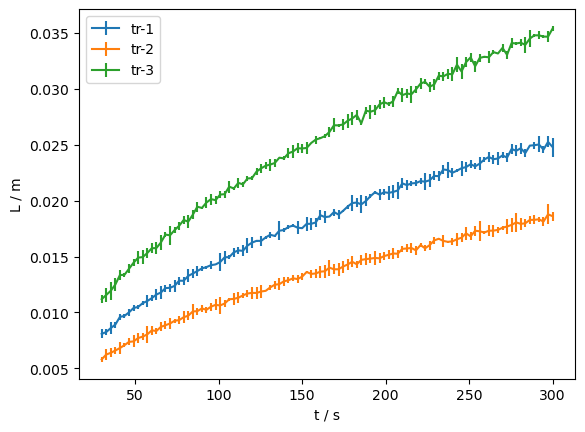

In [16]:
# show data plots

fig, ax = plt.subplots()

for i in range(1,4):
    data = pd.read_csv(f"datasets/tr-{i}.csv")
    x = data["t"]
    y = data["L"]
    dy = data["dL"]
    
    ax.errorbar(x,y,dy,label=f"tr-{i}")
    
ax.set_xlabel("t / s")
ax.set_ylabel("L / m")
ax.legend()

In [17]:
# assign time-resolved data to respective biscuit, in order from largest pore radius (Digestive) to smallest pore radius (Rich Tea)

tr_biscuits = [3,1,2]
for i, tr_val in enumerate(tr_biscuits):
    biscuit_summaries[biscuits[i]]['tr_vals'] = pd.read_csv(f"datasets/tr-{tr_val}.csv")
    
# show example of biscuit summary dictionary for one biscuit
biscuit_summaries['Digestive']

{'mean': 8.034173042885484e-07,
 'std': 5.96955948476585e-08,
 'tr_vals':              t         L        dL
 0    30.000000  0.011187  0.000371
 1    32.727273  0.011566  0.000609
 2    35.454545  0.011942  0.000809
 3    38.181818  0.012502  0.000614
 4    40.909091  0.013343  0.000480
 ..         ...       ...       ...
 95  289.090909  0.034766  0.000118
 96  291.818182  0.034769  0.000341
 97  294.545455  0.034655  0.000155
 98  297.272727  0.034646  0.000481
 99  300.000000  0.035373  0.000235
 
 [100 rows x 3 columns]}

Here, we test the effectiveness of the Washburn model. Each dataset has now been assigned to a biscuit. The pore radius of each biscuit used was not measured, so the average pore radius of each biscuit type (determined above) is used in each of the following models. 

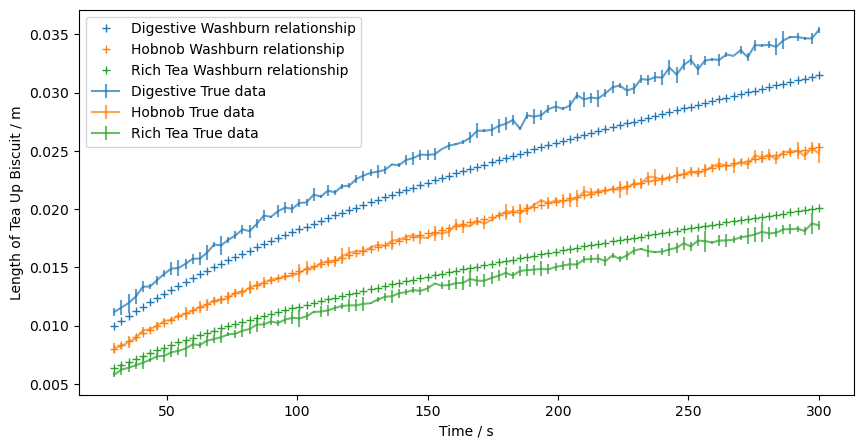

In [18]:
# washburn model fittings using average pore radii for each biscuit

fig, ax = plt.subplots(figsize=(10,5))

# Values measured for this specific experiment
gamma = 6.78e-2
phi = 1.45
eta = 9.93e-4

for i, biscuit in enumerate(biscuits):
    data = biscuit_summaries[biscuit]['tr_vals']
    t = data["t"]
    L = data["L"]
    dL = data["dL"]
    
    r = biscuit_summaries[biscuit]['mean']
    
    washburn_L_preds = washburn(gamma, phi, eta, r, t)
    ax.errorbar(t,L,dL,label=f"{biscuit} True data", alpha=0.7, color=f"C{i}")
    
    ax.plot(t, washburn_L_preds, marker='+', linestyle="", color=f"C{i}", zorder=3, label=f'{biscuit} Washburn relationship') 
    
ax.set_xlabel("Time / s")
ax.set_ylabel("Length of Tea Up Biscuit / m")
ax.legend()
plt.show()

This figure shows the Washburn relationship is likely an inaccurate model, as it does not seem to fit the Digestive or Rich Tea data effectively. However, there is a possibility the Digestive and Rich Tea biscuits used in these measurements had abnormally large/small pore sizes respectively. The following analysis determines the radii of the biscuits required for the Washburn model to accurately fit the real data. This will then be compared to the pore radius biscuit_summaries, to determine the likelihood these pore radii are accurate, or if the model is inaccurate. 

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [r]


Output()

Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 4 seconds.


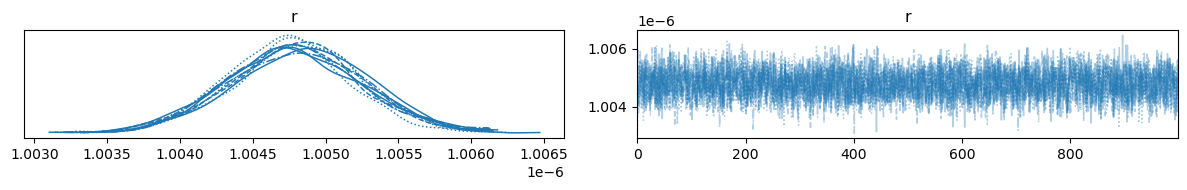

Initializing NUTS using jitter+adapt_diag...


Predicted pore radius: 1.004791682325701e-06


Multiprocess sampling (10 chains in 4 jobs)
NUTS: [r]


Output()

Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 4 seconds.


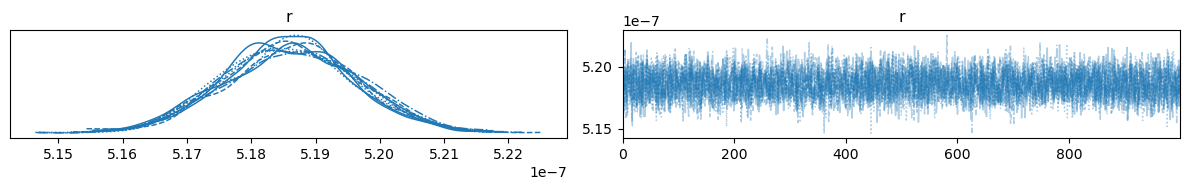

Initializing NUTS using jitter+adapt_diag...


Predicted pore radius: 5.186066088861517e-07


Multiprocess sampling (10 chains in 4 jobs)
NUTS: [r]


Output()

Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 6 seconds.


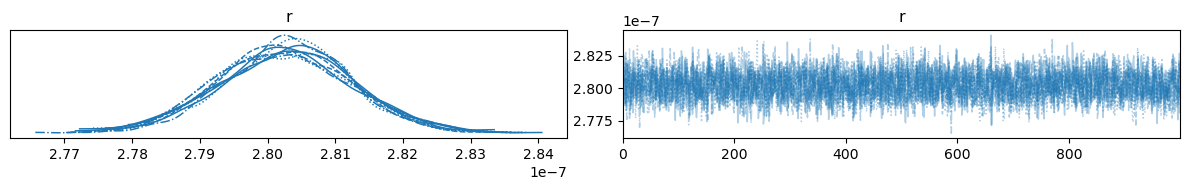

Predicted pore radius: 2.8026194770996414e-07


In [19]:
# find r for washburn to fit. 

for biscuit in biscuits:
    data = biscuit_summaries[biscuit]['tr_vals']
    
    pymc_r = run_pymc(data)
    
    print(f"Predicted pore radius: {pymc_r}")
    
    # add to summary dictionary
    biscuit_summaries[biscuit]['pymc_r'] = pymc_r


The required radius for the digestive comes out at over 1.0e-6, which is significantly greater than the mean. The following analysis determines the likelihood of each biscuit having the radius required for the Washburn model to fit effectively, using the particle size distributions determined further up. 

In [20]:
for biscuit in biscuits:
    print(biscuit)
    
    biscuit_dict = biscuit_summaries[biscuit]
    
    mean = biscuit_dict['mean']
    std = biscuit_dict['std'] 
    pymc_r = biscuit_dict['pymc_r']
    
    
    # Calculate probability of this radius occuring
    percentage_prob = calc_prob_in_distribution(mean, std, pymc_r)
    print(f"Probability of this value or a more extreme value occuring: {percentage_prob:.2f} %")
    
    # Calculate number of standard devisations of value from mean
    num_stds = calc_num_stds(mean, std, pymc_r)
    print(f"Number of stds from mean: {num_stds:.3}\n")
    
    biscuit_summaries[biscuit]['value_prob'] = percentage_prob
    biscuit_summaries[biscuit]['num_stds'] = num_stds


Digestive
Probability of this value or a more extreme value occuring: 0.07 %
Number of stds from mean: 3.37

Hobnob
Probability of this value or a more extreme value occuring: 98.39 %
Number of stds from mean: 0.0202

Rich Tea
Probability of this value or a more extreme value occuring: 61.94 %
Number of stds from mean: 0.497



In [21]:
# put data into csv file to be used in report

table_columns = ['Mean', 'Std', 'Required value', 'Probability of required value occuring', 'Number of stds value is from mean' ]
key_names = ['mean', 'std', 'pymc_r', 'value_prob', 'num_stds']
print(table_columns)

table1 = pd.DataFrame(columns=table_columns)
for biscuit in biscuits:
    for i, table_column in enumerate(table_columns):
        table1.loc[biscuit,table_column] = biscuit_summaries[biscuit][key_names[i]]
    
table1.to_csv('report_figures/probability_table.csv', index_label='Biscuit Type')

['Mean', 'Std', 'Required value', 'Probability of required value occuring', 'Number of stds value is from mean']


In [22]:
# Summary stats showing probability of Washburn relationship mis-fitting due to an incorrect radius size estimate

table1

,Mean,Std,Required value,Probability of required value occuring,Number of stds value is from mean
Digestive,0.000001,0.0,0.000001,0.074258,3.373354
Hobnob,0.000001,0.0,0.000001,98.3892,0.02019
Rich Tea,0.0,0.0,0.0,61.936349,0.496753


From this analysis, it is clear that the Washburn equation is not a good prediction model. The probability of the Washburn model being correct for Digestives is extremely low, as the chance of the required radius occuring is less than 0.06%. This suggests there is instead something wrong with the model. 

The Washburn model effectively predicts the relationship between L and t for Hobnobs. Furthermore, the model for the Rich Tea biscuit is likely correct, as the required radius for the probability is relatively likely to occur. However, the predicted model for the Digestives is very unlikely, which suggests the model can and should be improved.

### An improved model?

In this section, a correction factor is added to the Washburn relationship. This corrected model is compared to the original model for each biscuit type, to see if the corrected model signifcantly improves upon the original model. 

In [ ]:
# These functions are used for ultranest sampling. They require global variables, which are defined when called but cannot be input into the function.
# With more time I'd put them into the dunking_functions.py script. 


def likelihood(params, model):
    """
    Likelihood function for a model with Gaussian errors.
    
    params (?): Parameters of the model.
    model (func): Model to be used
    
    likelihood (float) The likelihood of the model given the data.
    """
    model_y = model(tr_data['t'], params)
    
    data_distribution = [norm(loc=loc, scale=scale) for loc, scale in zip(tr_data['L'], tr_data['dL'])]
    
    likelihood = np.sum([d.logpdf(m) for d, m in zip(data_distribution, model_y)])
    return likelihood


# functions used for the original model

def original_prior_transform(u):
    """
    Transform uniform random variables to the model parameters.
    
    u (?): Uniform random variables
    
    transformed_variables (list): Model parameters
    """
    transformed_variables = [p.ppf(u_) for p, u_ in zip(original_priors, u)]
    return transformed_variables


def original_model(t, params):
    """
    Normal Washburn Relationship
    
    t (pd.Series): Time values
    params (list): Parameters used in model
    
    L (arr): values for L
    """
    try:
        t=t.values.reshape(-1,1)
    except:
        raise ValueError("t is not a pandas series")
    
    r = biscuit_summaries[biscuit]['mean']
    gamma=6.78e-2
    phi=1.45
    eta=9.93e-4 
    
    L = washburn(gamma,phi,eta,r,t)
    
    # L at time t.
    return L

def likelihood_original(params):
    """
    Likelihood function for the original Washburn model.
    
    params (list?): Parameters used in model
    
    returns:
        likelihood
    """
    return likelihood(params, original_model)
# functions used for the original model

def corrected_prior_transform(u):
    """
    Transform uniform random variables to the model parameters.
    
    u (?): Uniform random variables
    
    transformed_variables (list): Model parameters
    """
    return [p.ppf(u_) for p, u_ in zip(corrected_priors, u)]

def corrected_model(t, params):
    """
    Corrected Washburn Relationship
    
    t (pd.Series): Time values
    params (list): Parameters used in model
    
    L_corrected (arr): values for corrected L
    """
    try:
        t=t.values.reshape(-1,1)
    except:
        raise ValueError("t is not a pandas series/ pandas dataframe column")
    
    # Correction factor!!
    a = params[0]
    
    r =  biscuit_summaries[biscuit]['mean']
    gamma=6.78e-2
    phi=1.45
    eta=9.93e-4 
    
    L = washburn(gamma,phi,eta,r,t)
    L_corrected = (a)*L 
    
    # L at time t.
    return L_corrected


def likelihood_corrected(params):
    """
    The likelihood function for the corrected model.
    
    params (list?): Parameters used in model
    
    returns:
        likelihood
    """
    return likelihood(params, corrected_model)

In [28]:
# determine an improved model using a correction factor. 
# from functools import partial

# record log(B) for later
log_Bs = []

# priors of each model
original_priors = []  
corrected_priors = [uniform(0, 10)]

for biscuit in biscuits:
    tr_data = biscuit_summaries[biscuit]['tr_vals']

    # run original model
    # original_prior_transform = lambda u: original_prior_transform(u, original_priors)
    # likelihood_original = lambda params: likelihood(params, original_model, tr_data)
    
    sampler_one = ultranest.ReactiveNestedSampler([], likelihood_original, original_prior_transform)
    sampler_one.run(show_status=False)
    sampler_one.print_results()

    # run corrected model
    # corrected_prior_transform = lambda u: corrected_prior_transform(u, corrected_priors)
    sampler_two = ultranest.ReactiveNestedSampler(['a'], likelihood_corrected, corrected_prior_transform)
    sampler_two.run(show_status=False)
    sampler_two.print_results()
    
    # add correction to summary stats
    biscuit_summaries[biscuit]['correction'] = sampler_two.results['posterior']['mean'][0]
    
    # record log(B)
    log_B = sampler_two.results['logz'] - sampler_one.results['logz']
    print(f"log_B: {log_B:.3}")
    
    log_Bs.append(log_B)

[ultranest] Sampling 400 live points from prior ...
[ultranest] Explored until L=-1e+05  
[ultranest] Likelihood function evaluations: 400
[ultranest]   logZ = -1.095e+05 +- 3.144e-11
[ultranest] Effective samples strategy satisfied (ESS = 400.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 40 minimum live points (dlogz from 0.00 to 0.00, need <0.5)
[ultranest]   logZ error budget: single: inf bs:0.00 tail:0.69 total:0.69 required:<0.50
[ultranest] done iterating.

logZ = -109536.925 +- 0.693
  single instance: logZ = -109536.925 +- nan
  bootstrapped   : logZ = -109536.925 +- -0.000
  tail           : logZ = +- 0.693
insert order U test : converged: True correlation: inf iterations


[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=4e+02  
[ultranest] Likelihood function evaluations: 5814
[ultranest]   logZ = 409.9 +- 0.09551
[ultranest] Effective samples strategy satisfied (ESS = 1243.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.04 total:0.10 required:<0.50
[ultranest] done iterating.

logZ = 409.877 +- 0.267
  single instance: logZ = 409.877 +- 0.153
  bootstrapped   : logZ = 409.909 +- 0.264
  tail           : logZ = +- 0.038
insert order U test : converged: True correlation: inf iterations

    a                   : 1.11725│ ▁  ▁▁▁▁▁▁▁▁▂▃▃▄▅▅▇▇▇▇▆▇▄▄▃▂▂▁▁▁▁▁▁▁▁▁ │1.11935    1.11834 +- 0.00025

log_B: 1.1e+05
[ultranest] Sampling 400 live points from prior ...
[ultranest] Explored until L=7e+02  
[ultranest] Likelihood function evaluations: 400
[ultranest]   logZ = 654.6 +- 1.724e-13

[ultranest] Explored until L=7e+02  
[ultranest] Likelihood function evaluations: 5058
[ultranest]   logZ = 648 +- 0.1
[ultranest] Effective samples strategy satisfied (ESS = 1228.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.10 tail:0.04 total:0.11 required:<0.50
[ultranest] done iterating.

logZ = 647.975 +- 0.172
  single instance: logZ = 647.975 +- 0.138
  bootstrapped   : logZ = 647.971 +- 0.167
  tail           : logZ = +- 0.038
insert order U test : converged: True correlation: inf iterations

    a                   : 0.99440│ ▁▁▁▁▁▁▁▁▂▂▂▂▄▄▅▇▆▇▇▆▆▅▅▄▃▂▂▁▁▁▁▁▁▁▁ ▁ │1.00250    0.99835 +- 0.00096

log_B: -6.6
[ultranest] Sampling 400 live points from prior ...
[ultranest] Explored until L=-4e+02  
[ultranest] Likelihood function evaluations: 400
[ultranest]   logZ = -409.5 +- 1.434e-13
[ultra

[ultranest] Explored until L=7e+02  
[ultranest] Likelihood function evaluations: 5026
[ultranest]   logZ = 649 +- 0.08099
[ultranest] Effective samples strategy satisfied (ESS = 1232.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.12 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.08 tail:0.03 total:0.09 required:<0.50
[ultranest] done iterating.

logZ = 649.039 +- 0.158
  single instance: logZ = 649.039 +- 0.136
  bootstrapped   : logZ = 649.020 +- 0.154
  tail           : logZ = +- 0.033
insert order U test : converged: True correlation: inf iterations

    a                   : 0.9196│ ▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆▇▇▇▇▇▆▆▅▃▃▂▁▁▁▁▁▁▁   ▁ │0.9331    0.9261 +- 0.0016

log_B: 1.06e+03


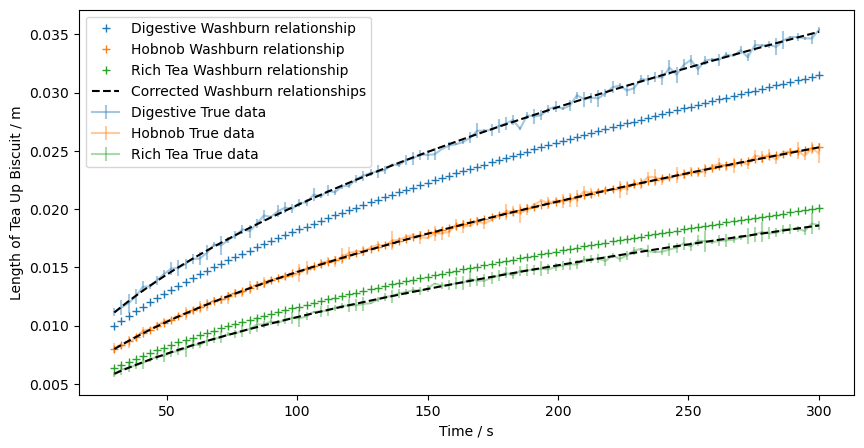

In [29]:
# corrected washburn model fittings   
table2 = pd.DataFrame(columns=(['log_B', 'Original model MSE', 'Corrected model MSE']))

fig, ax = plt.subplots(figsize=(10,5))

for i, biscuit in enumerate(biscuits):
    data = biscuit_summaries[biscuit]['tr_vals']
    t = data["t"]
    L = data["L"]
    dL = data["dL"]
    
    # calculate 
    washburn_L_preds = washburn(gamma, phi, eta, biscuit_summaries[biscuit]['mean'], t )
    ax.errorbar(t,L,dL,label=f"{biscuit} True data", alpha=0.4, color=f"C{i}", zorder=1)
    
    ax.plot(t, washburn_L_preds, marker='+', linestyle='', color=f"C{i}", zorder=3, label=f'{biscuit} Washburn relationship') 
    
    correction = biscuit_summaries[biscuit]['correction']
    if i == len(biscuits)-1:
        label = 'Corrected Washburn relationships'
    else:
        label=None
        
    corrected_model = (correction)*washburn_L_preds
    ax.plot(t, corrected_model, linestyle='--', color="black", zorder=5, label=label) 
    
    mse_original = mean_squared_error(L, washburn_L_preds)
    mse_corrected = mean_squared_error(L, corrected_model)
    
    table2.loc[biscuit] = [log_Bs[i], mse_original, mse_corrected]
    
ax.set_xlabel("Time / s")
ax.set_ylabel("Length of Tea Up Biscuit / m")
ax.legend()
plt.show()

table2.to_csv('report_figures/model_comparisons.csv', index_label='Biscuit Type')

In [30]:
# Comparison statistics between the two models.

table2

,log_B,Original model MSE,Corrected model MSE
Digestive,109946.802170,7.583382e-06,5.607198e-08
Hobnob,-6.597277,3.521289e-08,3.427062e-08
Rich Tea,1058.497339,1.284773e-06,1.728382e-08


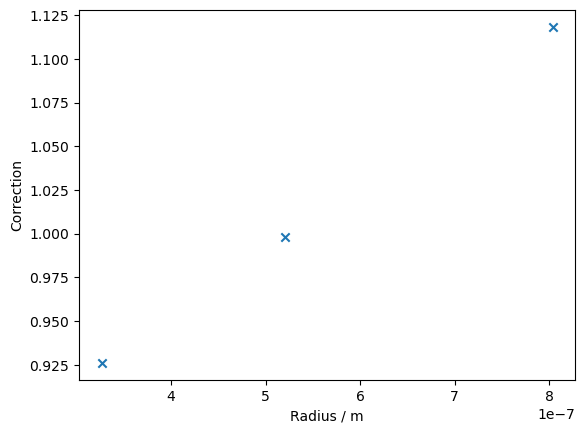

In [31]:
# relationship between corrections and (estimated) pore radius.

fig, ax = plt.subplots()

radii_mean = np.zeros(len(biscuits))
corrections = np.zeros(len(biscuits))
for i, biscuit in enumerate(biscuits):
    radii_mean[i] = (biscuit_summaries[biscuit]['mean'])
    corrections[i] = (biscuit_summaries[biscuit]['correction'])
    
ax.scatter(radii_mean, corrections, marker='x')

ax.set_xlabel('Radius / m')
ax.set_ylabel('Correction');

These corrections look like they may have a linear relationship, which would produce a neat wrapper for relating the correction function to readius. The following code determines the relationship and plots it. However, it should be considered that this relationship is very unreliable as there are only three data points. 

In [32]:
# find linear relationship

model = LinearRegression()

x = radii_mean.reshape(-1, 1)
y = corrections.reshape(-1, 1)

model.fit(x,y)

print(model.coef_)
print(model.intercept_)

[[404805.28544756]]
[0.79155273]


Relationship: y = 0.792 + 4.05e+05 * r


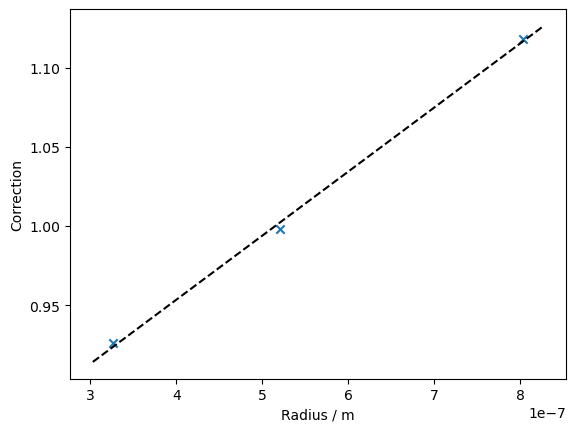

In [33]:
# Plot linear relationship

fig, ax = plt.subplots()

radii_mean = np.zeros(len(biscuits))
corrections = np.zeros(len(biscuits))

for i, biscuit in enumerate(biscuits):
    radii_mean[i] = (biscuit_summaries[biscuit]['mean'])
    corrections[i] = (biscuit_summaries[biscuit]['correction'])
    
ax.scatter(radii_mean, corrections, marker='x')

# Plot linear regression model
x_vals = np.array(ax.get_xlim())
y_vals = model.intercept_[0] + model.coef_[0][0] * x_vals
print(f"Relationship: y = {model.intercept_[0]:.3} + {model.coef_[0][0]:.3} * r")
ax.plot(x_vals, y_vals, linestyle='--', color='black')

ax.set_xlabel('Radius / m')
ax.set_ylabel('Correction');

In [34]:
# Calculate r**2 value of this linear regression model

predictions = model.predict(radii_mean.reshape(-1,1))

r2 = r2_score(predictions, corrections)

print(f"r2 value: {r2:.3}")

r2 value: 0.999


This figure and R^2 value suggests there may be a linear relationship between the correction factor and the pore radius of a biscuit. However, with only 3 data points, this relationship is very unreliable. This unreliability is enhanced by the fact that the true pore radii of each biscuit used in this analysis was not known. 

### Conclusion

The corresponding report will outline how the data produced can be used in future data-driven investigations. 